In [ ]:
!git clone https://github.com/Mayankjha1535/Alzheimer-s-Disease-Prediction-using-NLP

fatal: destination path 'Alzheimer-s-Disease-Prediction-using-NLP' already exists and is not an empty directory.


In [ ]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [ ]:
filename='/content/Alzheimer-s-Disease-Prediction-using-NLP/preprocessed_data.pkl'

In [ ]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [ ]:
len(data)

3243

In [ ]:
data.head()

,Transcript,AD
0,um young boy getting cookie jar,1
1,and it uh bad shape uh thing,1
2,and picture mother washing dish and see it,1
3,and dish might get falled,1
4,fell fall get it,1


In [ ]:
Y= data.iloc[:,1].values
Y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [ ]:
X = data['Transcript'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [ ]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

2594
649
2594
649


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [ ]:
train_tokenizer = create_tokens(X_train)

In [ ]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [ ]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [ ]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2594, 100)
(649, 100)
(2594,)
(649,)


In [ ]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

847

# CNN MODEL - Case 1: Training the model using randomly initialized embedding

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm

# BASIC CNN MODEL

In [ ]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
19/19 [==============================] - 2s 31ms/step - loss: 0.8204 - accuracy: 0.5049 - val_loss: 0.6983 - val_accuracy: 0.4423
Epoch 2/25
19/19 [==============================] - 0s 10ms/step - loss: 0.6672 - accuracy: 0.5947 - val_loss: 0.6900 - val_accuracy: 0.4885
Epoch 3/25
19/19 [==============================] - 0s 10ms/step - loss: 0.5842 - accuracy: 0.7013 - val_loss: 0.5685 - val_accuracy: 0.7231
Epoch 4/25
19/19 [==============================] - 0s 10ms/step - loss: 0.4499 - accuracy: 0.8000 - val_loss: 0.5050 - val_accuracy: 0.7538
Epoch 5/25
19/19 [==============================] - 0s 10ms/step - loss: 0.3733 - accuracy: 0.8308 - val_loss: 0.5136 - val_accuracy: 0.7769
Epoch 6/25
19/19 [==============================] - 0s 10ms/step - loss: 0.3249 - accuracy: 0.8623 - val_loss: 0.4309 - val_accuracy: 0.8038
Epoch 7/25
19/19 [==============================] - 0s 10ms/step - loss: 0.2565 - accuracy: 0.8916 - val_loss: 0.4177 - val_accuracy: 0.8269
Epoch 8/25
19

In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)

21/21 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.8521


In [ ]:
print('Accuracy of the model is {}'.format(score[1]))

Accuracy of the model is 0.8520801067352295


In [ ]:
Y_pred=model.predict(X_test)
Y_pred =(Y_pred>0.5)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[293  49]
 [ 47 260]]
precision is 0.8414239482200647
recall is  0.8469055374592834
F1 score 0.8441558441558441
specificity is 0.8567251461988304


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model.predict([x_val_f], batch_size=512)
    preds.append(model.predict(X_test))
    fold+=1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))

Fold 1, AUC = 0.9938151041666667
Fold 2, AUC = 0.9850260416666667
Fold 3, AUC = 0.9890074074074073
Fold 4, AUC = 0.9924192877103276
Fold 5, AUC = 0.9906062424969988
Fold 6, AUC = 0.9940947242206235
Fold 7, AUC = 0.990836749457439
Fold 8, AUC = 0.9972858506323072
Fold 9, AUC = 0.9902288188002475
Fold 10, AUC = 0.9899749373433584
Cross Validation AUC = 0.9913295163902044


# Hyperparameter tuning

In [ ]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    model.add(Embedding(input_dim = vocab_len, output_dim = 100, input_length = 100))
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 2s - loss: 0.6973 - accuracy: 0.5393
Epoch 2/10
65/65 - 0s - loss: 0.5547 - accuracy: 0.7224
Epoch 3/10
65/65 - 0s - loss: 0.4126 - accuracy: 0.8178
Epoch 4/10
65/65 - 0s - loss: 0.3160 - accuracy: 0.8631
Epoch 5/10
65/65 - 0s - loss: 0.2470 - accuracy: 0.8954
Epoch 6/10
65/65 - 0s - loss: 0.2010 - accuracy: 0.9190
Epoch 7/10
65/65 - 0s - loss: 0.1712 - accuracy: 0.9320
Epoch 8/10
65/65 - 0s - loss: 0.1514 - accuracy: 0.9417
Epoch 9/10
65/65 - 0s - loss: 0.1311 - accuracy: 0.9446
Epoch 10/10
65/65 - 0s - loss: 0.1257 - accuracy: 0.9427
17/17 - 0s - loss: 0.5681 - accuracy: 0.8304
[CV] ................................ optimizer=RMSprop, total=   5.2s
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


65/65 - 2s - loss: 0.6958 - accuracy: 0.5653
Epoch 2/10
65/65 - 0s - loss: 0.5389 - accuracy: 0.7219
Epoch 3/10
65/65 - 0s - loss: 0.3868 - accuracy: 0.8318
Epoch 4/10
65/65 - 0s - loss: 0.2839 - accuracy: 0.8814
Epoch 5/10
65/65 - 0s - loss: 0.2244 - accuracy: 0.9094
Epoch 6/10
65/65 - 0s - loss: 0.1837 - accuracy: 0.9243
Epoch 7/10
65/65 - 0s - loss: 0.1575 - accuracy: 0.9359
Epoch 8/10
65/65 - 0s - loss: 0.1368 - accuracy: 0.9436
Epoch 9/10
65/65 - 0s - loss: 0.1240 - accuracy: 0.9489
Epoch 10/10
65/65 - 0s - loss: 0.1167 - accuracy: 0.9523
17/17 - 0s - loss: 0.7031 - accuracy: 0.8382
[CV] ................................ optimizer=RMSprop, total=   4.8s
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
65/65 - 1s - loss: 0.6731 - accuracy: 0.5648
Epoch 2/10
65/65 - 0s - loss: 0.5078 - accuracy: 0.7533
Epoch 3/10
65/65 - 0s - loss: 0.3519 - accuracy: 0.8549
Epoch 4/10
65/65 - 0s - loss: 0.2604 - accuracy: 0.8911
Epoch 5/10
65/65 - 0s - loss: 0.2017 - 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished


82/82 - 2s - loss: 0.6864 - accuracy: 0.5786
Epoch 2/10
82/82 - 0s - loss: 0.5104 - accuracy: 0.7498
Epoch 3/10
82/82 - 0s - loss: 0.3562 - accuracy: 0.8443
Epoch 4/10
82/82 - 0s - loss: 0.2617 - accuracy: 0.8948
Epoch 5/10
82/82 - 0s - loss: 0.2090 - accuracy: 0.9167
Epoch 6/10
82/82 - 0s - loss: 0.1776 - accuracy: 0.9264
Epoch 7/10
82/82 - 0s - loss: 0.1553 - accuracy: 0.9356
Epoch 8/10
82/82 - 0s - loss: 0.1454 - accuracy: 0.9391
Epoch 9/10
82/82 - 0s - loss: 0.1341 - accuracy: 0.9449
Epoch 10/10
82/82 - 0s - loss: 0.1257 - accuracy: 0.9518
Best accuracy:  0.8307637810707093
Best parameters:  {'optimizer': 'RMSprop'}


In [ ]:
  param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5],
    'weight_constraint':[1,2,3,4,5],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 1s - loss: 0.6844 - accuracy: 0.5494
Epoch 2/10
65/65 - 0s - loss: 0.5565 - accuracy: 0.7046
Epoch 3/10
65/65 - 0s - loss: 0.3746 - accuracy: 0.8318
Epoch 4/10
65/65 - 0s - loss: 0.2698 - accuracy: 0.8829
Epoch 5/10
65/65 - 0s - loss: 0.2093 - accuracy: 0.9166
Epoch 6/10
65/65 - 0s - loss: 0.1758 - accuracy: 0.9229
Epoch 7/10
65/65 - 0s - loss: 0.1543 - accuracy: 0.9301
Epoch 8/10
65/65 - 0s - loss: 0.1313 - accuracy: 0.9455
Epoch 9/10
65/65 - 0s - loss: 0.1255 - accuracy: 0.9441
Epoch 10/10
65/65 - 0s - loss: 0.1185 - accuracy: 0.9460
17/17 - 0s - loss: 0.4776 - accuracy: 0.8362
[CV] ............ dropout_rate=0.1, weight_constraint=1, total=   5.0s
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


65/65 - 1s - loss: 0.6897 - accuracy: 0.5431
Epoch 2/10
65/65 - 0s - loss: 0.5902 - accuracy: 0.6863
Epoch 3/10
65/65 - 0s - loss: 0.4045 - accuracy: 0.8183
Epoch 4/10
65/65 - 0s - loss: 0.2979 - accuracy: 0.8872
Epoch 5/10
65/65 - 0s - loss: 0.2236 - accuracy: 0.9075
Epoch 6/10
65/65 - 0s - loss: 0.1870 - accuracy: 0.9272
Epoch 7/10
65/65 - 0s - loss: 0.1676 - accuracy: 0.9306
Epoch 8/10
65/65 - 0s - loss: 0.1434 - accuracy: 0.9412
Epoch 9/10
65/65 - 0s - loss: 0.1335 - accuracy: 0.9460
Epoch 10/10
65/65 - 0s - loss: 0.1193 - accuracy: 0.9552
17/17 - 0s - loss: 0.6530 - accuracy: 0.8247
[CV] ............ dropout_rate=0.1, weight_constraint=1, total=   5.0s
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10
65/65 - 1s - loss: 0.6881 - accuracy: 0.5518
Epoch 2/10
65/65 - 0s - loss: 0.5865 - accuracy: 0.6911
Epoch 3/10
65/65 - 0s - loss: 0.3939 - accuracy: 0.8183
Epoch 4/10
65/65 - 0s - loss: 0.2823 - accuracy: 0.8786
Epoch 5/10
65/65 - 0s - loss: 0.2231 - 

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.5min finished


82/82 - 2s - loss: 0.6703 - accuracy: 0.5810
Epoch 2/10
82/82 - 0s - loss: 0.4574 - accuracy: 0.7833
Epoch 3/10
82/82 - 0s - loss: 0.2945 - accuracy: 0.8720
Epoch 4/10
82/82 - 0s - loss: 0.2112 - accuracy: 0.9133
Epoch 5/10
82/82 - 0s - loss: 0.1804 - accuracy: 0.9229
Epoch 6/10
82/82 - 0s - loss: 0.1498 - accuracy: 0.9368
Epoch 7/10
82/82 - 0s - loss: 0.1359 - accuracy: 0.9383
Epoch 8/10
82/82 - 0s - loss: 0.1342 - accuracy: 0.9406
Epoch 9/10
82/82 - 0s - loss: 0.1224 - accuracy: 0.9487
Epoch 10/10
82/82 - 0s - loss: 0.1160 - accuracy: 0.9483
Best accuracy:  0.8330759525299072
Best parameters:  {'dropout_rate': 0.4, 'weight_constraint': 2}


# CNN MODEL WITH OPTIMISED PARAMETERS

In [ ]:
model1 = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model1.add(e)
model1.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model1.add(Dropout(0.5))
model1.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model1.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
cnn_history=model1.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
19/19 [==============================] - 2s 41ms/step - loss: 0.7134 - accuracy: 0.5130 - val_loss: 0.6888 - val_accuracy: 0.5692
Epoch 2/25
19/19 [==============================] - 0s 11ms/step - loss: 0.6776 - accuracy: 0.5954 - val_loss: 0.6676 - val_accuracy: 0.6154
Epoch 3/25
19/19 [==============================] - 0s 11ms/step - loss: 0.6273 - accuracy: 0.6716 - val_loss: 0.5839 - val_accuracy: 0.6923
Epoch 4/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5117 - accuracy: 0.7396 - val_loss: 0.5016 - val_accuracy: 0.7385
Epoch 5/25
19/19 [==============================] - 0s 11ms/step - loss: 0.3811 - accuracy: 0.8285 - val_loss: 0.4682 - val_accuracy: 0.7654
Epoch 6/25
19/19 [==============================] - 0s 11ms/step - loss: 0.3116 - accuracy: 0.8642 - val_loss: 0.4332 - val_accuracy: 0.8000
Epoch 7/25
19/19 [==============================] - 0s 11ms/step - loss: 0.2600 - accuracy: 0.8856 - val_loss: 0.4384 - val_accuracy: 0.7923
Epoch 8/25
19

In [ ]:
score = model1.evaluate(X_test,Y_test,verbose = 1)

21/21 [==============================] - 0s 5ms/step - loss: 0.6352 - accuracy: 0.8444


In [ ]:
print('Accuracy of the model is {}'.format(score[1]))     ###Accuracy on test data

Accuracy of the model is 0.8443759679794312


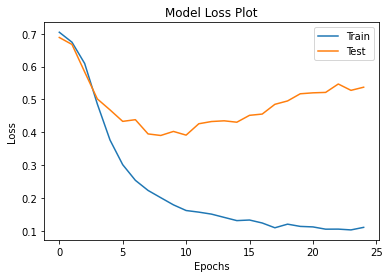

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
model1.save('cnn_model.hdf5')   ###save the model

In [ ]:
from tensorflow.keras.models import load_model  ###load the model

In [ ]:
model1.load_weights('cnn_model.hdf5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
Y_pred=model1.predict(X_test)
Y_pred =(Y_pred>0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[280  62]
 [ 39 268]]
precision is 0.8121212121212121
recall is  0.8729641693811075
F1 score 0.8414442700156987
specificity is 0.8187134502923976


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


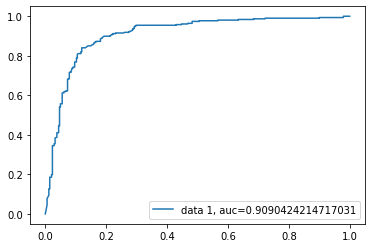

In [ ]:
Y_pred_proba = model1.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model1.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model1.predict([x_val_f], batch_size=256)
    preds.append(model1.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))    

Fold 1, AUC = 0.990915009469697
Fold 2, AUC = 0.9872159090909092
Fold 3, AUC = 0.9930962962962964
Fold 4, AUC = 0.9924192877103276
Fold 5, AUC = 0.9904861944777912
Fold 6, AUC = 0.9952937649880096
Fold 7, AUC = 0.9918013021461298
Fold 8, AUC = 0.998478883321403
Fold 9, AUC = 0.9910946196660483
Fold 10, AUC = 0.9916457811194652
Cross Validation AUC = 1.0


# CNN MODEL - Case 2: Train model using pretrained embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embeddings = dict()                                 ##read glove vector file
example1 = "/content/drive/MyDrive/glove.6B.100d (1).txt"
f = open(example1, "r")
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model2 = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
model2.add(e)
model2.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model2.add(Dropout(0.5))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model2.add(Dropout(0.5))
model2.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model2.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
cnn_pretrained_history=model2.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
19/19 [==============================] - 2s 30ms/step - loss: 0.6911 - accuracy: 0.5411 - val_loss: 0.6528 - val_accuracy: 0.6192
Epoch 2/25
19/19 [==============================] - 0s 9ms/step - loss: 0.6324 - accuracy: 0.6329 - val_loss: 0.6149 - val_accuracy: 0.6654
Epoch 3/25
19/19 [==============================] - 0s 8ms/step - loss: 0.5964 - accuracy: 0.6716 - val_loss: 0.5821 - val_accuracy: 0.6846
Epoch 4/25
19/19 [==============================] - 0s 8ms/step - loss: 0.5151 - accuracy: 0.7402 - val_loss: 0.5538 - val_accuracy: 0.7231
Epoch 5/25
19/19 [==============================] - 0s 8ms/step - loss: 0.4712 - accuracy: 0.7672 - val_loss: 0.5104 - val_accuracy: 0.7692
Epoch 6/25
19/19 [==============================] - 0s 8ms/step - loss: 0.4173 - accuracy: 0.8009 - val_loss: 0.4941 - val_accuracy: 0.7885
Epoch 7/25
19/19 [==============================] - 0s 8ms/step - loss: 0.4022 - accuracy: 0.8155 - val_loss: 0.4424 - val_accuracy: 0.7769
Epoch 8/25
19/19 [=

In [ ]:
score = model2.evaluate(X_test,Y_test,verbose = 1)

21/21 [==============================] - 0s 3ms/step - loss: 0.4702 - accuracy: 0.8505


In [ ]:
score[1]

0.8505392670631409

In [ ]:
Y_pred=model2.predict(X_test)
Y_pred =(Y_pred>0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[292  50]
 [ 47 260]]
precision is 0.8387096774193549
recall is  0.8469055374592834
F1 score 0.8427876823338736
specificity is 0.8538011695906432


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model2.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model2.predict([x_val_f], batch_size=512)
    preds.append(model2.predict(X_test))
    fold+=1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))

Fold 1, AUC = 0.9908558238636365
Fold 2, AUC = 0.9850852272727273
Fold 3, AUC = 0.9915555555555555
Fold 4, AUC = 0.9906950472679708
Fold 5, AUC = 0.9902460984393757
Fold 6, AUC = 0.9944544364508394
Fold 7, AUC = 0.9914395948878707
Fold 8, AUC = 0.9984192316869482
Fold 9, AUC = 0.9907854050711195
Fold 10, AUC = 0.9912280701754387
Cross Validation AUC = 0.9914764490671482


# Hyperparameter tuning

In [ ]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model3 = Sequential()
    e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
    model3.add(e)
    model3.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model3.add(MaxPooling1D(pool_size = 2))
    model3.add(Flatten())
    model3.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model3.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model3.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model3

In [ ]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 1s - loss: 0.6582 - accuracy: 0.6275
Epoch 2/10
65/65 - 0s - loss: 0.4956 - accuracy: 0.7528
Epoch 3/10
65/65 - 0s - loss: 0.3523 - accuracy: 0.8434
Epoch 4/10
65/65 - 0s - loss: 0.2606 - accuracy: 0.8935
Epoch 5/10
65/65 - 0s - loss: 0.2132 - accuracy: 0.9104
Epoch 6/10
65/65 - 0s - loss: 0.1832 - accuracy: 0.9243
Epoch 7/10
65/65 - 0s - loss: 0.1580 - accuracy: 0.9359
Epoch 8/10
65/65 - 0s - loss: 0.1519 - accuracy: 0.9345
Epoch 9/10
65/65 - 0s - loss: 0.1350 - accuracy: 0.9436
Epoch 10/10
65/65 - 0s - loss: 0.1232 - accuracy: 0.9417
17/17 - 0s - loss: 0.5473 - accuracy: 0.8478
[CV] ................................ optimizer=RMSprop, total=   4.1s
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


65/65 - 1s - loss: 0.6676 - accuracy: 0.6043
Epoch 2/10
65/65 - 0s - loss: 0.4918 - accuracy: 0.7619
Epoch 3/10
65/65 - 0s - loss: 0.3317 - accuracy: 0.8549
Epoch 4/10
65/65 - 0s - loss: 0.2455 - accuracy: 0.8892
Epoch 5/10
65/65 - 0s - loss: 0.1923 - accuracy: 0.9166
Epoch 6/10
65/65 - 0s - loss: 0.1635 - accuracy: 0.9316
Epoch 7/10
65/65 - 0s - loss: 0.1506 - accuracy: 0.9402
Epoch 8/10
65/65 - 0s - loss: 0.1261 - accuracy: 0.9455
Epoch 9/10
65/65 - 0s - loss: 0.1258 - accuracy: 0.9441
Epoch 10/10
65/65 - 0s - loss: 0.1161 - accuracy: 0.9484
17/17 - 0s - loss: 0.7545 - accuracy: 0.8189
[CV] ................................ optimizer=RMSprop, total=   4.1s
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
65/65 - 1s - loss: 0.6704 - accuracy: 0.6082
Epoch 2/10
65/65 - 0s - loss: 0.5026 - accuracy: 0.7561
Epoch 3/10
65/65 - 0s - loss: 0.3532 - accuracy: 0.8482
Epoch 4/10
65/65 - 0s - loss: 0.2578 - accuracy: 0.8892
Epoch 5/10
65/65 - 0s - loss: 0.2135 - 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   57.6s finished


82/82 - 1s - loss: 0.6542 - accuracy: 0.6203
Epoch 2/10
82/82 - 0s - loss: 0.4648 - accuracy: 0.7841
Epoch 3/10
82/82 - 0s - loss: 0.3109 - accuracy: 0.8747
Epoch 4/10
82/82 - 0s - loss: 0.2365 - accuracy: 0.9013
Epoch 5/10
82/82 - 0s - loss: 0.1902 - accuracy: 0.9183
Epoch 6/10
82/82 - 0s - loss: 0.1699 - accuracy: 0.9295
Epoch 7/10
82/82 - 0s - loss: 0.1604 - accuracy: 0.9341
Epoch 8/10
82/82 - 0s - loss: 0.1435 - accuracy: 0.9375
Epoch 9/10
82/82 - 0s - loss: 0.1313 - accuracy: 0.9429
Epoch 10/10
82/82 - 0s - loss: 0.1209 - accuracy: 0.9437
Best accuracy:  0.8242105126380921
Best parameters:  {'optimizer': 'RMSprop'}


In [ ]:
param_grid = {
    'neurons': [128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] neurons=128 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 1s - loss: 0.6479 - accuracy: 0.6222
Epoch 2/10
65/65 - 0s - loss: 0.4799 - accuracy: 0.7720
Epoch 3/10
65/65 - 0s - loss: 0.3143 - accuracy: 0.8689
Epoch 4/10
65/65 - 0s - loss: 0.2326 - accuracy: 0.9084
Epoch 5/10
65/65 - 0s - loss: 0.1821 - accuracy: 0.9229
Epoch 6/10
65/65 - 0s - loss: 0.1571 - accuracy: 0.9364
Epoch 7/10
65/65 - 0s - loss: 0.1523 - accuracy: 0.9441
Epoch 8/10
65/65 - 0s - loss: 0.1371 - accuracy: 0.9422
Epoch 9/10
65/65 - 0s - loss: 0.1238 - accuracy: 0.9499
Epoch 10/10
65/65 - 0s - loss: 0.1179 - accuracy: 0.9475
17/17 - 0s - loss: 0.4666 - accuracy: 0.8497
[CV] ...................................... neurons=128, total=   4.2s
[CV] neurons=128 .....................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


65/65 - 1s - loss: 0.6653 - accuracy: 0.5986
Epoch 2/10
65/65 - 0s - loss: 0.5017 - accuracy: 0.7605
Epoch 3/10
65/65 - 0s - loss: 0.3245 - accuracy: 0.8646
Epoch 4/10
65/65 - 0s - loss: 0.2270 - accuracy: 0.9036
Epoch 5/10
65/65 - 0s - loss: 0.1930 - accuracy: 0.9277
Epoch 6/10
65/65 - 0s - loss: 0.1529 - accuracy: 0.9369
Epoch 7/10
65/65 - 0s - loss: 0.1295 - accuracy: 0.9446
Epoch 8/10
65/65 - 0s - loss: 0.1243 - accuracy: 0.9523
Epoch 9/10
65/65 - 0s - loss: 0.1198 - accuracy: 0.9480
Epoch 10/10
65/65 - 0s - loss: 0.1039 - accuracy: 0.9557
17/17 - 0s - loss: 0.5851 - accuracy: 0.8362
[CV] ...................................... neurons=128, total=   3.6s
[CV] neurons=128 .....................................................
Epoch 1/10
65/65 - 1s - loss: 0.6583 - accuracy: 0.6169
Epoch 2/10
65/65 - 0s - loss: 0.5232 - accuracy: 0.7398
Epoch 3/10
65/65 - 0s - loss: 0.3527 - accuracy: 0.8448
Epoch 4/10
65/65 - 0s - loss: 0.2570 - accuracy: 0.8911
Epoch 5/10
65/65 - 0s - loss: 0.1921 - 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.8s finished


82/82 - 1s - loss: 0.6363 - accuracy: 0.6376
Epoch 2/10
82/82 - 0s - loss: 0.4387 - accuracy: 0.7864
Epoch 3/10
82/82 - 0s - loss: 0.3059 - accuracy: 0.8755
Epoch 4/10
82/82 - 0s - loss: 0.2263 - accuracy: 0.9067
Epoch 5/10
82/82 - 0s - loss: 0.1838 - accuracy: 0.9225
Epoch 6/10
82/82 - 0s - loss: 0.1632 - accuracy: 0.9352
Epoch 7/10
82/82 - 0s - loss: 0.1422 - accuracy: 0.9453
Epoch 8/10
82/82 - 0s - loss: 0.1482 - accuracy: 0.9387
Epoch 9/10
82/82 - 0s - loss: 0.1358 - accuracy: 0.9402
Epoch 10/10
82/82 - 0s - loss: 0.1451 - accuracy: 0.9414
Best accuracy:  0.8292149305343628
Best parameters:  {'neurons': 128}


In [ ]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 1s - loss: 0.6577 - accuracy: 0.6029
Epoch 2/10
65/65 - 0s - loss: 0.5280 - accuracy: 0.7378
Epoch 3/10
65/65 - 0s - loss: 0.4032 - accuracy: 0.8149
Epoch 4/10
65/65 - 0s - loss: 0.2897 - accuracy: 0.8786
Epoch 5/10
65/65 - 0s - loss: 0.2323 - accuracy: 0.9060
Epoch 6/10
65/65 - 0s - loss: 0.1827 - accuracy: 0.9267
Epoch 7/10
65/65 - 0s - loss: 0.1558 - accuracy: 0.9349
Epoch 8/10
65/65 - 0s - loss: 0.1535 - accuracy: 0.9412
Epoch 9/10
65/65 - 0s - loss: 0.1371 - accuracy: 0.9417
Epoch 10/10
65/65 - 0s - loss: 0.1297 - accuracy: 0.9489
17/17 - 0s - loss: 0.4586 - accuracy: 0.8632
[CV] .................... kernel_size=3, nb_filters=128, total=   3.8s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


65/65 - 1s - loss: 0.6781 - accuracy: 0.5764
Epoch 2/10
65/65 - 0s - loss: 0.5700 - accuracy: 0.6867
Epoch 3/10
65/65 - 0s - loss: 0.4164 - accuracy: 0.8111
Epoch 4/10
65/65 - 0s - loss: 0.3046 - accuracy: 0.8675
Epoch 5/10
65/65 - 0s - loss: 0.2343 - accuracy: 0.9055
Epoch 6/10
65/65 - 0s - loss: 0.1825 - accuracy: 0.9239
Epoch 7/10
65/65 - 0s - loss: 0.1551 - accuracy: 0.9398
Epoch 8/10
65/65 - 0s - loss: 0.1481 - accuracy: 0.9412
Epoch 9/10
65/65 - 0s - loss: 0.1327 - accuracy: 0.9475
Epoch 10/10
65/65 - 0s - loss: 0.1166 - accuracy: 0.9528
17/17 - 0s - loss: 0.6068 - accuracy: 0.8170
[CV] .................... kernel_size=3, nb_filters=128, total=   4.1s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
65/65 - 1s - loss: 0.6620 - accuracy: 0.5928
Epoch 2/10
65/65 - 0s - loss: 0.5415 - accuracy: 0.7345
Epoch 3/10
65/65 - 0s - loss: 0.4231 - accuracy: 0.8140
Epoch 4/10
65/65 - 0s - loss: 0.2981 - accuracy: 0.8800
Epoch 5/10
65/65 - 0s - loss: 0.2380 - 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


82/82 - 1s - loss: 0.6474 - accuracy: 0.6137
Epoch 2/10
82/82 - 0s - loss: 0.4615 - accuracy: 0.7764
Epoch 3/10
82/82 - 0s - loss: 0.3058 - accuracy: 0.8693
Epoch 4/10
82/82 - 0s - loss: 0.2179 - accuracy: 0.9113
Epoch 5/10
82/82 - 0s - loss: 0.1918 - accuracy: 0.9221
Epoch 6/10
82/82 - 0s - loss: 0.1685 - accuracy: 0.9322
Epoch 7/10
82/82 - 0s - loss: 0.1457 - accuracy: 0.9433
Epoch 8/10
82/82 - 0s - loss: 0.1360 - accuracy: 0.9460
Epoch 9/10
82/82 - 0s - loss: 0.1249 - accuracy: 0.9449
Epoch 10/10
82/82 - 0s - loss: 0.1220 - accuracy: 0.9491
Best accuracy:  0.8303702473640442
Best parameters:  {'kernel_size': 5, 'nb_filters': 256}


In [ ]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] dropout_rate=0.1 ................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 1s - loss: 0.6610 - accuracy: 0.5976
Epoch 2/10
65/65 - 0s - loss: 0.5117 - accuracy: 0.7465
Epoch 3/10
65/65 - 0s - loss: 0.3371 - accuracy: 0.8549
Epoch 4/10
65/65 - 0s - loss: 0.2259 - accuracy: 0.9108
Epoch 5/10
65/65 - 0s - loss: 0.1922 - accuracy: 0.9200
Epoch 6/10
65/65 - 0s - loss: 0.1607 - accuracy: 0.9335
Epoch 7/10
65/65 - 0s - loss: 0.1506 - accuracy: 0.9388
Epoch 8/10
65/65 - 0s - loss: 0.1336 - accuracy: 0.9427
Epoch 9/10
65/65 - 0s - loss: 0.1293 - accuracy: 0.9417
Epoch 10/10
65/65 - 0s - loss: 0.1161 - accuracy: 0.9480
17/17 - 0s - loss: 0.4882 - accuracy: 0.8459
[CV] ................................. dropout_rate=0.1, total=   3.7s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


65/65 - 1s - loss: 0.6454 - accuracy: 0.6125
Epoch 2/10
65/65 - 0s - loss: 0.4624 - accuracy: 0.7836
Epoch 3/10
65/65 - 0s - loss: 0.3193 - accuracy: 0.8617
Epoch 4/10
65/65 - 0s - loss: 0.2237 - accuracy: 0.9108
Epoch 5/10
65/65 - 0s - loss: 0.1864 - accuracy: 0.9267
Epoch 6/10
65/65 - 0s - loss: 0.1458 - accuracy: 0.9460
Epoch 7/10
65/65 - 0s - loss: 0.1308 - accuracy: 0.9451
Epoch 8/10
65/65 - 0s - loss: 0.1245 - accuracy: 0.9528
Epoch 9/10
65/65 - 0s - loss: 0.1243 - accuracy: 0.9480
Epoch 10/10
65/65 - 0s - loss: 0.1185 - accuracy: 0.9508
17/17 - 0s - loss: 0.5817 - accuracy: 0.8343
[CV] ................................. dropout_rate=0.1, total=   3.7s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
65/65 - 1s - loss: 0.6663 - accuracy: 0.5952
Epoch 2/10
65/65 - 0s - loss: 0.5073 - accuracy: 0.7446
Epoch 3/10
65/65 - 0s - loss: 0.3329 - accuracy: 0.8588
Epoch 4/10
65/65 - 0s - loss: 0.2584 - accuracy: 0.8949
Epoch 5/10
65/65 - 0s - loss: 0.1967 - 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.6min finished


82/82 - 1s - loss: 0.6523 - accuracy: 0.6153
Epoch 2/10
82/82 - 0s - loss: 0.4878 - accuracy: 0.7691
Epoch 3/10
82/82 - 0s - loss: 0.3363 - accuracy: 0.8524
Epoch 4/10
82/82 - 0s - loss: 0.2421 - accuracy: 0.9029
Epoch 5/10
82/82 - 0s - loss: 0.1920 - accuracy: 0.9256
Epoch 6/10
82/82 - 0s - loss: 0.1762 - accuracy: 0.9306
Epoch 7/10
82/82 - 0s - loss: 0.1557 - accuracy: 0.9410
Epoch 8/10
82/82 - 0s - loss: 0.1456 - accuracy: 0.9414
Epoch 9/10
82/82 - 0s - loss: 0.1424 - accuracy: 0.9429
Epoch 10/10
82/82 - 0s - loss: 0.1363 - accuracy: 0.9464
Best accuracy:  0.8311446785926819
Best parameters:  {'dropout_rate': 0.1}


In [ ]:
param_grid = {
    'weight_constraint': [1,2,3,4,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] weight_constraint=1 .............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 1s - loss: 0.6622 - accuracy: 0.5745
Epoch 2/10
65/65 - 0s - loss: 0.5005 - accuracy: 0.7581
Epoch 3/10
65/65 - 0s - loss: 0.3426 - accuracy: 0.8530
Epoch 4/10
65/65 - 0s - loss: 0.2523 - accuracy: 0.9046
Epoch 5/10
65/65 - 0s - loss: 0.2011 - accuracy: 0.9113
Epoch 6/10
65/65 - 0s - loss: 0.1787 - accuracy: 0.9263
Epoch 7/10
65/65 - 0s - loss: 0.1490 - accuracy: 0.9378
Epoch 8/10
65/65 - 0s - loss: 0.1361 - accuracy: 0.9470
Epoch 9/10
65/65 - 0s - loss: 0.1298 - accuracy: 0.9484
Epoch 10/10
65/65 - 0s - loss: 0.1135 - accuracy: 0.9480
17/17 - 0s - loss: 0.5363 - accuracy: 0.8362
[CV] .............................. weight_constraint=1, total=   3.7s
[CV] weight_constraint=1 .............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


65/65 - 1s - loss: 0.6681 - accuracy: 0.5995
Epoch 2/10
65/65 - 0s - loss: 0.5187 - accuracy: 0.7600
Epoch 3/10
65/65 - 0s - loss: 0.3489 - accuracy: 0.8472
Epoch 4/10
65/65 - 0s - loss: 0.2480 - accuracy: 0.8973
Epoch 5/10
65/65 - 0s - loss: 0.1782 - accuracy: 0.9325
Epoch 6/10
65/65 - 0s - loss: 0.1553 - accuracy: 0.9383
Epoch 7/10
65/65 - 0s - loss: 0.1364 - accuracy: 0.9431
Epoch 8/10
65/65 - 0s - loss: 0.1339 - accuracy: 0.9436
Epoch 9/10
65/65 - 0s - loss: 0.1182 - accuracy: 0.9508
Epoch 10/10
65/65 - 0s - loss: 0.1089 - accuracy: 0.9489
17/17 - 0s - loss: 0.6901 - accuracy: 0.8131
[CV] .............................. weight_constraint=1, total=   3.8s
[CV] weight_constraint=1 .............................................
Epoch 1/10
65/65 - 1s - loss: 0.6568 - accuracy: 0.6154
Epoch 2/10
65/65 - 0s - loss: 0.5131 - accuracy: 0.7581
Epoch 3/10
65/65 - 0s - loss: 0.3497 - accuracy: 0.8602
Epoch 4/10
65/65 - 0s - loss: 0.2554 - accuracy: 0.8993
Epoch 5/10
65/65 - 0s - loss: 0.1970 - 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.6min finished


82/82 - 1s - loss: 0.6566 - accuracy: 0.5944
Epoch 2/10
82/82 - 0s - loss: 0.4824 - accuracy: 0.7656
Epoch 3/10
82/82 - 0s - loss: 0.3306 - accuracy: 0.8562
Epoch 4/10
82/82 - 0s - loss: 0.2587 - accuracy: 0.8986
Epoch 5/10
82/82 - 0s - loss: 0.2193 - accuracy: 0.9140
Epoch 6/10
82/82 - 0s - loss: 0.1715 - accuracy: 0.9287
Epoch 7/10
82/82 - 0s - loss: 0.1501 - accuracy: 0.9348
Epoch 8/10
82/82 - 0s - loss: 0.1405 - accuracy: 0.9429
Epoch 9/10
82/82 - 0s - loss: 0.1315 - accuracy: 0.9429
Epoch 10/10
82/82 - 0s - loss: 0.1244 - accuracy: 0.9437
Best accuracy:  0.8307585835456848
Best parameters:  {'weight_constraint': 2}


In [ ]:
param_grid = {
    'batch_size': [32,64,128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] batch_size=32 ...................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


65/65 - 1s - loss: 0.6779 - accuracy: 0.5855
Epoch 2/10
65/65 - 0s - loss: 0.5406 - accuracy: 0.7210
Epoch 3/10
65/65 - 0s - loss: 0.3819 - accuracy: 0.8304
Epoch 4/10
65/65 - 0s - loss: 0.2620 - accuracy: 0.8940
Epoch 5/10
65/65 - 0s - loss: 0.1907 - accuracy: 0.9234
Epoch 6/10
65/65 - 0s - loss: 0.1711 - accuracy: 0.9311
Epoch 7/10
65/65 - 0s - loss: 0.1445 - accuracy: 0.9431
Epoch 8/10
65/65 - 0s - loss: 0.1334 - accuracy: 0.9451
Epoch 9/10
65/65 - 0s - loss: 0.1278 - accuracy: 0.9480
Epoch 10/10
65/65 - 0s - loss: 0.1220 - accuracy: 0.9499
17/17 - 0s - loss: 0.4868 - accuracy: 0.8420
[CV] .................................... batch_size=32, total=   3.7s
[CV] batch_size=32 ...................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


65/65 - 1s - loss: 0.6574 - accuracy: 0.6149
Epoch 2/10
65/65 - 0s - loss: 0.4867 - accuracy: 0.7576
Epoch 3/10
65/65 - 0s - loss: 0.3042 - accuracy: 0.8814
Epoch 4/10
65/65 - 0s - loss: 0.2187 - accuracy: 0.9104
Epoch 5/10
65/65 - 0s - loss: 0.1764 - accuracy: 0.9335
Epoch 6/10
65/65 - 0s - loss: 0.1478 - accuracy: 0.9436
Epoch 7/10
65/65 - 0s - loss: 0.1426 - accuracy: 0.9422
Epoch 8/10
65/65 - 0s - loss: 0.1221 - accuracy: 0.9513
Epoch 9/10
65/65 - 0s - loss: 0.1096 - accuracy: 0.9513
Epoch 10/10
65/65 - 0s - loss: 0.1187 - accuracy: 0.9518
17/17 - 0s - loss: 0.6739 - accuracy: 0.8170
[CV] .................................... batch_size=32, total=   3.7s
[CV] batch_size=32 ...................................................
Epoch 1/10
65/65 - 1s - loss: 0.6630 - accuracy: 0.5961
Epoch 2/10
65/65 - 0s - loss: 0.5070 - accuracy: 0.7407
Epoch 3/10
65/65 - 0s - loss: 0.3389 - accuracy: 0.8578
Epoch 4/10
65/65 - 0s - loss: 0.2358 - accuracy: 0.9036
Epoch 5/10
65/65 - 0s - loss: 0.1917 - 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   57.8s finished


41/41 - 2s - loss: 0.6771 - accuracy: 0.5756
Epoch 2/10
41/41 - 0s - loss: 0.5658 - accuracy: 0.7020
Epoch 3/10
41/41 - 0s - loss: 0.3951 - accuracy: 0.8277
Epoch 4/10
41/41 - 0s - loss: 0.2900 - accuracy: 0.8836
Epoch 5/10
41/41 - 0s - loss: 0.2283 - accuracy: 0.9102
Epoch 6/10
41/41 - 0s - loss: 0.1885 - accuracy: 0.9229
Epoch 7/10
41/41 - 0s - loss: 0.1522 - accuracy: 0.9422
Epoch 8/10
41/41 - 0s - loss: 0.1422 - accuracy: 0.9456
Epoch 9/10
41/41 - 0s - loss: 0.1505 - accuracy: 0.9375
Epoch 10/10
41/41 - 0s - loss: 0.1372 - accuracy: 0.9453
Best accuracy:  0.8288243532180786
Best parameters:  {'batch_size': 64}


# CNN-Pretrained Embedding MODEL WITH OPTIMISED PARAMETERS

In [ ]:
model4 = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
model4.add(e)
model4.add(Conv1D(filters=256,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model4.add(Dropout(0.5))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(1)))
model4.add(Dropout(0.5))
model4.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model4.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
cnn_pretrained_history=model4.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/25
73/73 [==============================] - 2s 13ms/step - loss: 0.7004 - accuracy: 0.5695 - val_loss: 0.6326 - val_accuracy: 0.6500
Epoch 2/25
73/73 [==============================] - 0s 5ms/step - loss: 0.5962 - accuracy: 0.6727 - val_loss: 0.5909 - val_accuracy: 0.6923
Epoch 3/25
73/73 [==============================] - 0s 5ms/step - loss: 0.5348 - accuracy: 0.7378 - val_loss: 0.5397 - val_accuracy: 0.7462
Epoch 4/25
73/73 [==============================] - 0s 5ms/step - loss: 0.4716 - accuracy: 0.7786 - val_loss: 0.4918 - val_accuracy: 0.7808
Epoch 5/25
73/73 [==============================] - 0s 5ms/step - loss: 0.4054 - accuracy: 0.8066 - val_loss: 0.4494 - val_accuracy: 0.7769
Epoch 6/25
73/73 [==============================] - 0s 5ms/step - loss: 0.3554 - accuracy: 0.8432 - val_loss: 0.4127 - val_accuracy: 0.8154
Epoch 7/25
73/73 [==============================] - 0s 5ms/step - loss: 0.3056 - accuracy: 0.8607 - val_loss: 0.4059 - val_accuracy: 0.7923
Epoch 8/25
73/73 [=

In [ ]:
score = model4.evaluate(X_test,Y_test,verbose = 1)
score[1]

21/21 [==============================] - 0s 5ms/step - loss: 0.5196 - accuracy: 0.8505


0.8505392670631409

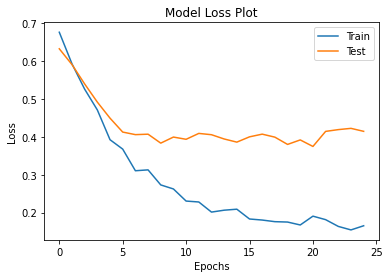

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_pretrained_history.history['loss'])
plt.plot(cnn_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
model4.save('cnn_pretrained_model.hdf5')

In [ ]:
model4.load_weights('cnn_pretrained_model.hdf5')

In [ ]:
Y_pred = model4.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[293  49]
 [ 48 259]]
precision is 0.8409090909090909
recall is  0.8436482084690554
F1 score 0.8422764227642277
specificity is 0.8567251461988304


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


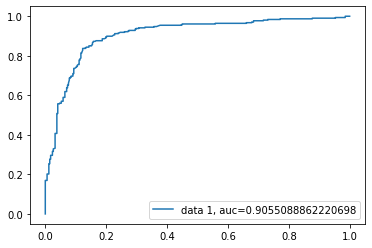

In [ ]:
Y_pred_proba = model4.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model4.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model4.predict([x_val_f], batch_size=256)
    preds.append(model4.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))    

Fold 1, AUC = 0.9925722064393939
Fold 2, AUC = 0.9883404356060607
Fold 3, AUC = 0.9927407407407406
Fold 4, AUC = 0.9927165705452167
Fold 5, AUC = 0.9910264105642256
Fold 6, AUC = 0.9948741007194245
Fold 7, AUC = 0.9924644321196046
Fold 8, AUC = 0.9973455022667622
Fold 9, AUC = 0.9922077922077922
Fold 10, AUC = 0.9921231650554959
Cross Validation AUC = 1.0
